Reading classics [Python Machine Learning 3rd Edition](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch15/ch15_part2.ipynb)

In [1]:
from IPython.display import display,HTML
c1,c2,f1,f2,fs1,fs2=\
'#11ff66','#6611ff','Wallpoet','Orbitron',20,10
def dhtml(string,fontcolor=c1,font=f1,fontsize=fs1):
    display(HTML("""<style>
    @import 'https://fonts.googleapis.com/css?family="""\
    +font+"""&effect=3d-float';</style>
    <h1 class='font-effect-3d-float' 
    style='font-family:"""+font+\
    """; color:"""+fontcolor+\
    """; font-size:"""+str(fontsize)+"""px;'>
    %s</h1>"""%string))

In [2]:
!pip install mplcyberpunk

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
dhtml('Code Modules, Setting, & Functions')

In [4]:
import warnings,imageio,urllib,mplcyberpunk
import tensorflow as tf,pylab as pl
import pandas as pd,numpy as np
import tensorflow.keras.layers as tkl
import tensorflow.keras.utils as tku
import tensorflow.keras.callbacks as tkc
import tensorflow_datasets as tfds
from sklearn.metrics import \
classification_report,confusion_matrix
from IPython.core.magic import register_line_magic

In [5]:
warnings.filterwarnings('ignore')
pd.set_option('precision',3)
tf.keras.backend.set_floatx('float64')
tfds.disable_progress_bar()
pl.style.use("cyberpunk")
fpath='../input/image-examples-for-mixed-styles/'
fn1,fn2='flower.png','cat.png'
fw='weights.best.hdf5'
buffer_size,batch_size=500,128
pixels,pixels2=64,128
num_classes=5

In [6]:
def show2(img1,img2):
    pl.subplot(1,2,1); pl.imshow(img1)
    pl.subplot(1,2,2); pl.imshow(img2)
    pl.show()
def preprocess(item,img_size):
    img,lbl=item['image'],item['label']
    img_cropped=tf.image.central_crop(img,.95)
    img_resized=tf.image.resize(
        img_cropped,size=(img_size,img_size))
    img_flip=tf.image\
    .random_flip_left_right(img_resized)
    return (img_flip/255.,tf.cast(lbl,tf.int32))
@register_line_magic
def display_examples(pars):
    pars=pars.split()
    data,n=pars[0],int(pars[1])
    if data=='cats_vs_dogs': data=cvd_test
    if data=='tf_flowers': data=flower_test
    batch=next(iter(data.batch(n)))
    images=batch[0].numpy()
    labels=batch[1].numpy() 
    fig=pl.figure(figsize=(2*n//3,4.5))
    for i in range(n):
        ax=fig.add_subplot(3,n//3,i+1)
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(images[i])
        ax.text(.85,.15,'{}'.format(labels[i]), 
                fontdict={'color':c1,'fontsize':30},
                horizontalalignment='center',
                verticalalignment='center', 
                transform=ax.transAxes)
    pl.show()
@register_line_magic
def history_plot(yes):
    global history
    pl.figure(figsize=(10,10)); pl.subplot(211)
    keys=list(history.history.keys())[0:4]
    pl.plot(history.history[keys[0]],
            color=c1,label='train')
    pl.plot(history.history[keys[2]],
            color=c2,label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Loss")
    pl.legend(); pl.grid()
    pl.title('Loss Function')     
    pl.subplot(212)
    pl.plot(history.history[keys[1]],
            color=c1,label='train')
    pl.plot(history.history[keys[3]],
            color=c2,label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Accuracy")    
    pl.legend(); pl.grid()
    pl.title('Accuracy')
    mplcyberpunk.add_glow_effects(); pl.show()
def cb(fw):
    early_stopping=\
    tkc.EarlyStopping(monitor='val_loss',
                      patience=10,verbose=2)
    checkpointer=\
    tkc.ModelCheckpoint(filepath=fw,
                        save_best_only=True,verbose=2)
    lr_reduction=\
    tkc.ReduceLROnPlateau(monitor='val_loss',verbose=2,
                          patience=5,factor=.75)
    return [checkpointer,early_stopping,
            lr_reduction]
@register_line_magic
def display_reports(d):
    global model,fw,buffer_size,c2,f2,fs2
    model.load_weights(fw)
    if d=='cats_vs_dogs': data=cvd_test
    if d=='tf_flowers': data=flower_test
    test_results=model.evaluate(data.batch(buffer_size))
    dhtml('\ntest accuracy: {:.2f}%'\
          .format(test_results[1]*100),
          c2,f2,fs2)
    batch=next(iter(data.batch(buffer_size)))
    y_test=batch[1].numpy()
    py_test=model.predict(data.batch(buffer_size))
    if d=='cats_vs_dogs':
        py_test=tf.sigmoid(py_test)\
                  .numpy().round()
    if d=='tf_flowers':
        py_test=np.argmax(tf.nn.softmax(py_test)\
                            .numpy(),axis=-1)
    py_test=py_test[:buffer_size]
    dhtml('Classification Report',c2,f2,fs2)
    print(classification_report(y_test,py_test))
    dhtml('Confusion Matrix',c2,f2,fs2)
    print(confusion_matrix(y_test,py_test))

In [7]:
dhtml('Image Structure')

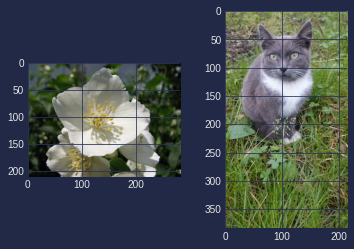

,flower,cat
shape,"(211, 282, 3)","(384, 216, 3)"
dtype,uint8,uint8
rank,3,3


In [8]:
imgtf1=tf.image.decode_image(tf.io.read_file(fpath+fn1))
imgtf2=tf.image.decode_image(tf.io.read_file(fpath+fn2))
show2(imgtf1,imgtf2)
pd.DataFrame([[str(imgtf1.numpy().shape),
               str(imgtf2.numpy().shape)],
              [imgtf1.numpy().dtype,
               imgtf2.numpy().dtype],
              [tf.rank(imgtf1).numpy(),
               tf.rank(imgtf2).numpy()]],
            index=['shape','dtype','rank'],
            columns=['flower','cat'])

In [9]:
dhtml('Image Processing')

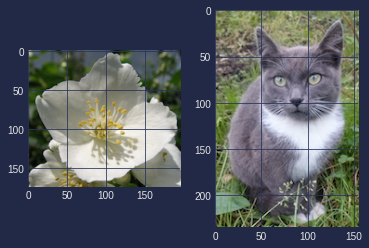

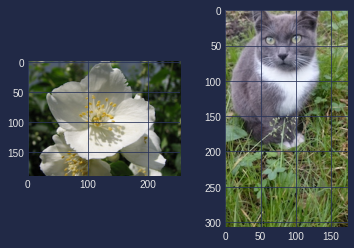

In [10]:
def bcrop(img,box):
    return tf.image.crop_to_bounding_box(
        img,box[0],box[1],box[2],box[3])
def ccrop(img,c):
    return tf.image.central_crop(img,c)
show2(bcrop(imgtf1,[5,35,175,195]),
      bcrop(imgtf2,[5,15,235,155]))
show2(ccrop(imgtf1,.9),ccrop(imgtf2,.8))

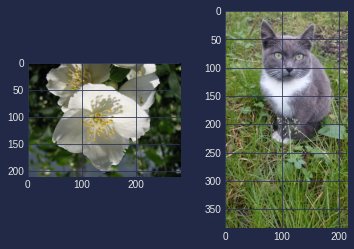

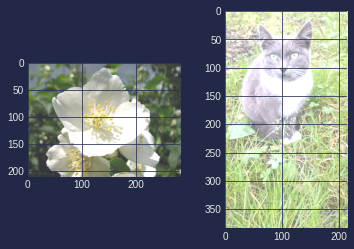

In [11]:
def hflip(img):
    return tf.image.flip_left_right(img)
def vflip(img):
    return tf.image.flip_up_down(img)
def bright(img,d):
    return tf.image.adjust_brightness(
        img,delta=d)
show2(vflip(imgtf1),hflip(imgtf2))
show2(bright(imgtf1,.2),bright(imgtf2,.4))

In [12]:
dhtml('Data Processing')

In [13]:
cvd=tfds.builder('cats_vs_dogs:4.0.0')
cvd.download_and_prepare()
split=['train[:80%]','train[80%:90%]','train[90%:]']
ds=cvd.as_dataset(shuffle_files=False,split=split)
cvd_train=ds[0].map(lambda x: preprocess(x,img_size=pixels))
cvd_valid=ds[1].map(lambda x: preprocess(x,img_size=pixels))
cvd_test=ds[2].map(lambda x: preprocess(x,img_size=pixels))
ncvd_train=int(cvd.info.splits['train[:80%]'].num_examples)
dhtml(str(ncvd_train),c2,f2,fs2)

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete8T6TVB/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


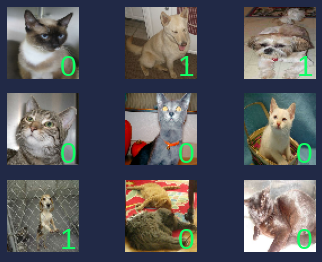

In [14]:
dhtml(cvd.info.features['image'],c2,f2,fs2)
dhtml(cvd.info.features['label'],c2,f2,fs2)
%display_examples cats_vs_dogs 9

In [15]:
cvd_train=cvd_train\
.shuffle(buffer_size=buffer_size).repeat()
cvd_train=cvd_train.batch(batch_size)
cvd_valid=cvd_valid.batch(batch_size)

In [16]:
flower=tfds.builder('tf_flowers')
flower.download_and_prepare()
split=['train[:80%]','train[80%:90%]','train[90%:]']
ds=flower.as_dataset(shuffle_files=False,split=split)
flower_train=ds[0].map(lambda x: preprocess(x,img_size=pixels2))
flower_valid=ds[1].map(lambda x: preprocess(x,img_size=pixels2))
flower_test=ds[2].map(lambda x: preprocess(x,img_size=pixels2))
nflower_train=int(flower.info.splits['train[:80%]'].num_examples)
dhtml(str(nflower_train),c2,f2,fs2)

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


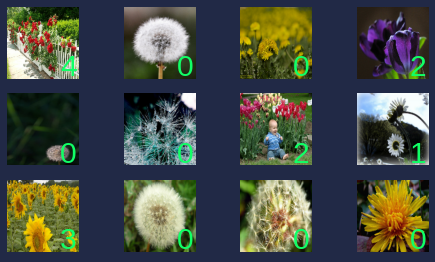

In [17]:
dhtml(flower.info.features['image'],c2,f2,fs2)
dhtml(flower.info.features['label'],c2,f2,fs2)
%display_examples tf_flowers 12

In [18]:
flower_train=flower_train\
.shuffle(buffer_size=buffer_size).repeat()
flower_train=flower_train.batch(batch_size)
flower_valid=flower_valid.batch(batch_size)

In [19]:
dhtml('CNN Binary Classification')

In [20]:
def convb(model,f,ks,d):
    model.add(tkl.Conv2D(
    filters=f,kernel_size=(ks,ks),
    strides=(1,1),padding='same'))
    model.add(tkl.LeakyReLU(alpha=.02))
    model.add(tkl.MaxPool2D(pool_size=(2,2)))
    model.add(tkl.Dropout(d))

In [21]:
model=tf.keras.Sequential()
model.add(tkl.Input((pixels,pixels,3),
                    name='input'))
convb(model,32,5,.2)
convb(model,128,5,.2)
convb(model,512,5,.2)
model.compute_output_shape(
    input_shape=(batch_size,pixels,pixels,3))

TensorShape([128, 8, 8, 512])

In [22]:
model.add(tkl.GlobalAveragePooling2D())   
model.add(tkl.Dense(2048))
model.add(tkl.LeakyReLU(alpha=.02))
model.add(tkl.Dropout(.5))
model.add(tkl.Dense(1,activation=None))
model.compute_output_shape(
    input_shape=(batch_size,pixels,pixels,1))

TensorShape([128, 1])

In [23]:
steps_per_epoch=np.ceil(ncvd_train/batch_size)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses\
              .BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
history=model.fit(cvd_train,epochs=50,shuffle=True, 
                  validation_data=cvd_valid,
                  callbacks=cb(fw),
                  steps_per_epoch=steps_per_epoch)

Epoch 1/50
146/146 [==============================] - ETA: 0s - loss: 0.6791 - accuracy: 0.5353
Epoch 00001: val_loss improved from inf to 0.65004, saving model to weights.best.hdf5
146/146 [==============================] - 123s 846ms/step - loss: 0.6791 - accuracy: 0.5353 - val_loss: 0.6500 - val_accuracy: 0.5705
Epoch 2/50
146/146 [==============================] - ETA: 0s - loss: 0.6488 - accuracy: 0.5801
Epoch 00002: val_loss improved from 0.65004 to 0.62943, saving model to weights.best.hdf5
146/146 [==============================] - 123s 843ms/step - loss: 0.6488 - accuracy: 0.5801 - val_loss: 0.6294 - val_accuracy: 0.6285
Epoch 3/50
146/146 [==============================] - ETA: 0s - loss: 0.6016 - accuracy: 0.6477
Epoch 00003: val_loss improved from 0.62943 to 0.59558, saving model to weights.best.hdf5
146/146 [==============================] - 123s 842ms/step - loss: 0.6016 - accuracy: 0.6477 - val_loss: 0.5956 - val_accuracy: 0.5963
Epoch 4/50
146/146 [=====================

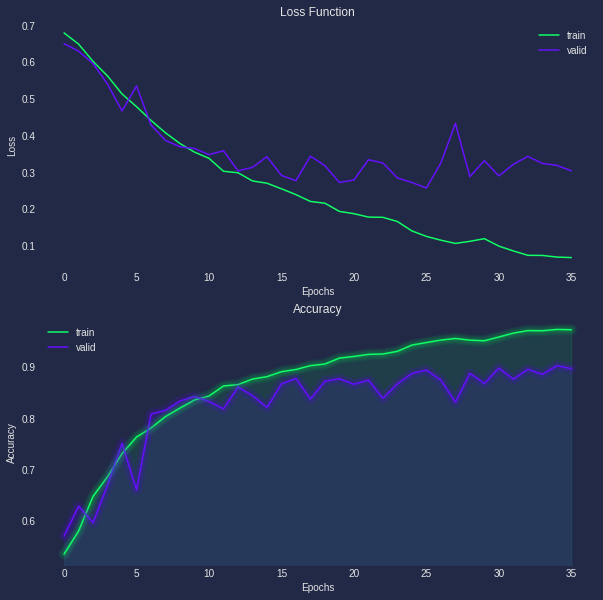

In [24]:
%history_plot yes

In [25]:
%display_reports cats_vs_dogs

5/5 [==============================] - 14s 3s/step - loss: 0.2395 - accuracy: 0.9080


              precision    recall  f1-score   support

           0       0.89      0.90      0.89       256
           1       0.89      0.89      0.89       244

    accuracy                           0.89       500
   macro avg       0.89      0.89      0.89       500
weighted avg       0.89      0.89      0.89       500



[[230  26]
 [ 28 216]]


In [26]:
dhtml('CNN Classification')

In [27]:
model=tf.keras.Sequential()
model.add(tkl.Input((pixels2,pixels2,3),
                    name='input'))
convb(model,32,5,.2)
convb(model,64,5,.2)
convb(model,128,5,.2)
convb(model,256,5,.2)
convb(model,512,5,.2)
model.compute_output_shape(
    input_shape=(batch_size,pixels2,pixels2,3))

TensorShape([128, 4, 4, 512])

In [28]:
model.add(tkl.GlobalAveragePooling2D())   
model.add(tkl.Dense(4096))
model.add(tkl.LeakyReLU(alpha=.02))
model.add(tkl.Dropout(.5))
model.add(tkl.Dense(num_classes,activation=None))
model.compute_output_shape(
    input_shape=(batch_size,pixels2,pixels2,3))

TensorShape([128, 5])

In [29]:
steps_per_epoch=np.ceil(nflower_train/batch_size)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses\
              .SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history=model.fit(flower_train,epochs=50,shuffle=True, 
                  validation_data=flower_valid,
                  callbacks=cb(fw),
                  steps_per_epoch=steps_per_epoch)

Epoch 1/50
23/23 [==============================] - ETA: 0s - loss: 1.6540 - accuracy: 0.2401
Epoch 00001: val_loss improved from inf to 1.60095, saving model to weights.best.hdf5
23/23 [==============================] - 26s 1s/step - loss: 1.6540 - accuracy: 0.2401 - val_loss: 1.6010 - val_accuracy: 0.2425
Epoch 2/50
23/23 [==============================] - ETA: 0s - loss: 1.5388 - accuracy: 0.2959
Epoch 00002: val_loss improved from 1.60095 to 1.48013, saving model to weights.best.hdf5
23/23 [==============================] - 21s 903ms/step - loss: 1.5388 - accuracy: 0.2959 - val_loss: 1.4801 - val_accuracy: 0.4033
Epoch 3/50
23/23 [==============================] - ETA: 0s - loss: 1.3293 - accuracy: 0.4236
Epoch 00003: val_loss improved from 1.48013 to 1.25508, saving model to weights.best.hdf5
23/23 [==============================] - 21s 922ms/step - loss: 1.3293 - accuracy: 0.4236 - val_loss: 1.2551 - val_accuracy: 0.4441
Epoch 4/50
23/23 [==============================] - ETA: 0s

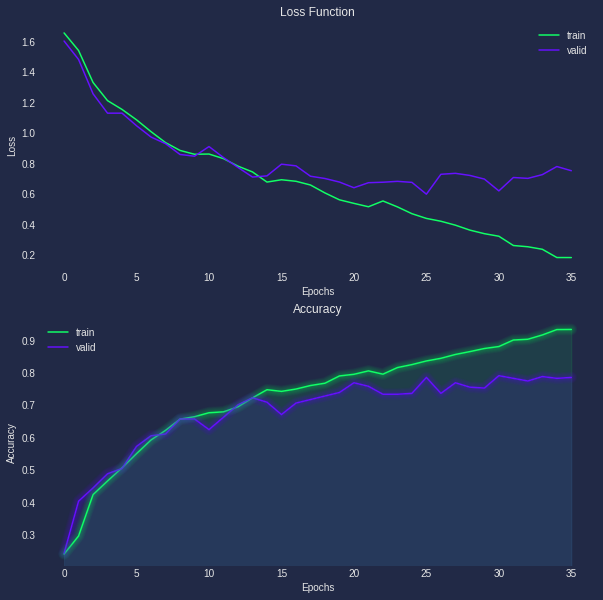

In [30]:
%history_plot yes

In [31]:
%display_reports tf_flowers

1/1 [==============================] - 0s 2ms/step - loss: 0.4880 - accuracy: 0.8283


              precision    recall  f1-score   support

           0       0.75      0.89      0.81        70
           1       0.88      0.87      0.88        61
           2       0.75      0.79      0.77        85
           3       0.93      0.88      0.91        76
           4       0.78      0.65      0.71        75

    accuracy                           0.81       367
   macro avg       0.82      0.82      0.81       367
weighted avg       0.82      0.81      0.81       367



[[62  2  1  4  1]
 [ 5 53  2  0  1]
 [ 4  2 67  0 12]
 [ 5  2  2 67  0]
 [ 7  1 17  1 49]]
